In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.initializers import Constant, RandomNormal

from sklearn.metrics import mean_squared_error
from astroNN.nn.layers import MCDropout

2023-07-11 22:58:18.542991: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 22:58:19.091829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-07-11 22:58:19.644947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 22:58:19.667496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 22:58:19.667673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


2023-07-11 22:58:19.697223: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 22:58:19.698027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 22:58:19.698870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


2023-07-11 22:58:20.193000: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 22:58:20.193246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-11 22:58:20.193380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
data_folder = 'Data_SNIa_LSST/larger/'
df_data = pd.read_csv(data_folder+'hubble_diagram.txt', skiprows=5, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702


In [6]:
len(df_data)

5785

In [7]:
# df_cov = pd.read_csv(data_folder+'covsys_000.txt', sep='\\n')
# df_cov.head()

In [8]:
# cov = df_cov.values
# len(cov)

In [9]:
# cov = cov.reshape((len(df_data), len(df_data)))
# np.shape(cov)

In [10]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,CID,IDSURVEY,zCMB,zHEL,MU,MUERR,MUERR_VPEC,MUERR_SYS,errors
0,SN:2521,50,0.01988,0.01988,34.84680,0.1320,0.0736,0.00796,0.13996
1,SN:57482,50,0.02321,0.02321,34.89863,0.1551,0.0631,0.00720,0.16230
2,SN:52921,50,0.02364,0.02364,35.28915,0.1243,0.0620,0.00771,0.13201
3,SN:21365,50,0.02470,0.02470,35.11988,0.1444,0.0594,0.00717,0.15157
4,SN:117311,50,0.02471,0.02471,35.19347,0.1232,0.0593,0.00702,0.13022


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


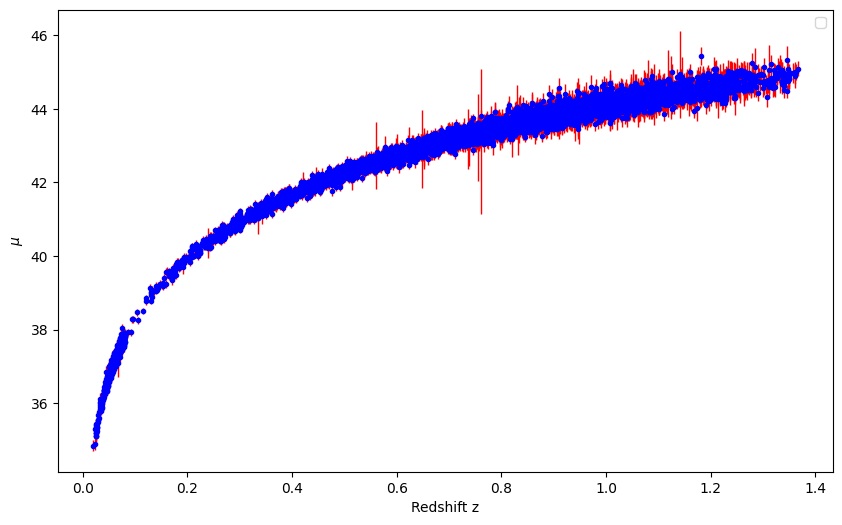

In [11]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(df_data['zCMB'].values, df_data['MU'].values, yerr=df_data['errors'].values, fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.legend()

In [12]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [13]:
len(df_data)

5785

In [14]:
df_data.head()

,zCMB,MU,errors
0,0.01988,34.84680,0.13996
1,0.02321,34.89863,0.16230
2,0.02364,35.28915,0.13201
3,0.02470,35.11988,0.15157
4,0.02471,35.19347,0.13022


In [15]:
z = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values

randomize = np.random.permutation(len(z))
z = z[randomize]
y = y[randomize]

In [16]:
zmin, zmax = np.min(z), np.max(z)
zmin, zmax

(0.01988, 1.36643)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


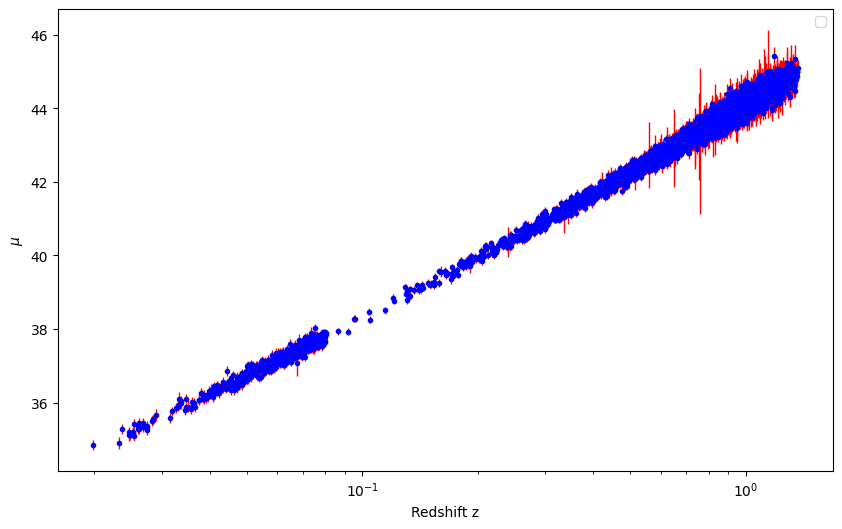

In [17]:
fig = plt.figure(figsize=(10, 6))
plt.errorbar(z, y[:,0], yerr=y[:,1], fmt='.', color='b', elinewidth=1, ecolor='red')
plt.ylabel("$\mu$")
plt.xlabel("Redshift z")
plt.xscale('log')
plt.legend()

In [18]:
scalerz = StandardScaler()
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

In [19]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [20]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [21]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
yy_train = np.append(yy_train, np.array([y[0], y[-1]]))
zz_train = np.append(zz_train, np.array([zz[0], zz[-1]]))
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((4630,), (4632,), (1157, 1), (1157, 1))

In [22]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.5))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 32
# optimizer = Adam(lr=.005)
optimizer = Adam(learning_rate=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[100,200,100])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               200       
                                                                 
 MCDropout_1 (MCDropout)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 MCDropout_2 (MCDropout)     (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 MCDropout_3 (MCDropout)     (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 2

In [23]:
model.compile(loss='mse', optimizer=optimizer) 
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500)
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=500, verbose=1,
                                    validation_data=(z_test, y_test), callbacks=callback)

Epoch 1/500
145/145 [==============================] - 1s 2ms/step - loss: 869.3819 - val_loss: 792.4021
Epoch 2/500
145/145 [==============================] - 0s 2ms/step - loss: 582.2368 - val_loss: 308.2850
Epoch 3/500
145/145 [==============================] - 0s 2ms/step - loss: 199.9630 - val_loss: 155.0396
Epoch 4/500
145/145 [==============================] - 0s 2ms/step - loss: 128.1537 - val_loss: 107.9810
Epoch 5/500
145/145 [==============================] - 0s 2ms/step - loss: 99.3861 - val_loss: 84.6920
Epoch 6/500
145/145 [==============================] - 0s 2ms/step - loss: 79.8023 - val_loss: 69.4407
Epoch 7/500
145/145 [==============================] - 0s 2ms/step - loss: 66.3941 - val_loss: 63.1487
Epoch 8/500
145/145 [==============================] - 0s 2ms/step - loss: 59.3234 - val_loss: 57.1841
Epoch 9/500
145/145 [==============================] - 0s 2ms/step - loss: 50.5578 - val_loss: 47.3048
Epoch 10/500
145/145 [==============================] - 0s 2ms/st

Epoch 80/500
145/145 [==============================] - 0s 2ms/step - loss: 19.5391 - val_loss: 18.8875
Epoch 81/500
145/145 [==============================] - 0s 2ms/step - loss: 18.6447 - val_loss: 18.7206
Epoch 82/500
145/145 [==============================] - 0s 2ms/step - loss: 18.6996 - val_loss: 19.3104
Epoch 83/500
145/145 [==============================] - 0s 2ms/step - loss: 19.2641 - val_loss: 18.2619
Epoch 84/500
145/145 [==============================] - 0s 2ms/step - loss: 19.0171 - val_loss: 18.3400
Epoch 85/500
145/145 [==============================] - 0s 2ms/step - loss: 18.7230 - val_loss: 19.3809
Epoch 86/500
145/145 [==============================] - 0s 2ms/step - loss: 18.4251 - val_loss: 17.9783
Epoch 87/500
145/145 [==============================] - 0s 2ms/step - loss: 18.4772 - val_loss: 18.9232
Epoch 88/500
145/145 [==============================] - 0s 2ms/step - loss: 18.7927 - val_loss: 17.5628
Epoch 89/500
145/145 [==============================] - 0s 2ms/s

145/145 [==============================] - 0s 2ms/step - loss: 16.7266 - val_loss: 17.4871
Epoch 159/500
145/145 [==============================] - 0s 2ms/step - loss: 17.4932 - val_loss: 15.9582
Epoch 160/500
145/145 [==============================] - 0s 2ms/step - loss: 16.7234 - val_loss: 16.3514
Epoch 161/500
145/145 [==============================] - 0s 2ms/step - loss: 16.5651 - val_loss: 18.0879
Epoch 162/500
145/145 [==============================] - 0s 2ms/step - loss: 17.1424 - val_loss: 17.2490
Epoch 163/500
145/145 [==============================] - 0s 2ms/step - loss: 16.6817 - val_loss: 16.6957
Epoch 164/500
145/145 [==============================] - 0s 2ms/step - loss: 17.1753 - val_loss: 17.1030
Epoch 165/500
145/145 [==============================] - 0s 2ms/step - loss: 16.9502 - val_loss: 17.1706
Epoch 166/500
145/145 [==============================] - 0s 2ms/step - loss: 16.2899 - val_loss: 16.5666
Epoch 167/500
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 15.3802 - val_loss: 15.1859
Epoch 237/500
145/145 [==============================] - 0s 2ms/step - loss: 16.0975 - val_loss: 16.1831
Epoch 238/500
145/145 [==============================] - 0s 2ms/step - loss: 15.8055 - val_loss: 15.7415
Epoch 239/500
145/145 [==============================] - 0s 2ms/step - loss: 15.7701 - val_loss: 15.6323
Epoch 240/500
145/145 [==============================] - 0s 2ms/step - loss: 15.9356 - val_loss: 15.9713
Epoch 241/500
145/145 [==============================] - 0s 2ms/step - loss: 15.4053 - val_loss: 15.5270
Epoch 242/500
145/145 [==============================] - 0s 2ms/step - loss: 15.7418 - val_loss: 15.8168
Epoch 243/500
145/145 [==============================] - 0s 2ms/step - loss: 16.2216 - val_loss: 15.8167
Epoch 244/500
145/145 [==============================] - 0s 2ms/step - loss: 15.1445 - val_loss: 15.1482
Epoch 245/500
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 14.8092 - val_loss: 15.0469
Epoch 315/500
145/145 [==============================] - 0s 2ms/step - loss: 14.6946 - val_loss: 13.5477
Epoch 316/500
145/145 [==============================] - 0s 2ms/step - loss: 14.8857 - val_loss: 16.1395
Epoch 317/500
145/145 [==============================] - 0s 2ms/step - loss: 14.9242 - val_loss: 14.5448
Epoch 318/500
145/145 [==============================] - 0s 2ms/step - loss: 14.7615 - val_loss: 14.6357
Epoch 319/500
145/145 [==============================] - 0s 2ms/step - loss: 14.6219 - val_loss: 14.6279
Epoch 320/500
145/145 [==============================] - 0s 2ms/step - loss: 15.0769 - val_loss: 14.6812
Epoch 321/500
145/145 [==============================] - 0s 2ms/step - loss: 14.8890 - val_loss: 14.1298
Epoch 322/500
145/145 [==============================] - 0s 2ms/step - loss: 14.4500 - val_loss: 14.9744
Epoch 323/500
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 13.9994 - val_loss: 12.2724
Epoch 393/500
145/145 [==============================] - 0s 2ms/step - loss: 13.8339 - val_loss: 13.4670
Epoch 394/500
145/145 [==============================] - 0s 2ms/step - loss: 13.6963 - val_loss: 13.8830
Epoch 395/500
145/145 [==============================] - 0s 2ms/step - loss: 13.8667 - val_loss: 14.8254
Epoch 396/500
145/145 [==============================] - 0s 2ms/step - loss: 13.4792 - val_loss: 13.9346
Epoch 397/500
145/145 [==============================] - 0s 2ms/step - loss: 14.0367 - val_loss: 14.6845
Epoch 398/500
145/145 [==============================] - 0s 2ms/step - loss: 14.1514 - val_loss: 13.2956
Epoch 399/500
145/145 [==============================] - 0s 2ms/step - loss: 13.9477 - val_loss: 12.4958
Epoch 400/500
145/145 [==============================] - 0s 2ms/step - loss: 13.6727 - val_loss: 13.9840
Epoch 401/500
145/145 [==============================] - 0s 2ms/step 

145/145 [==============================] - 0s 2ms/step - loss: 12.9905 - val_loss: 13.0270
Epoch 471/500
145/145 [==============================] - 0s 2ms/step - loss: 12.9711 - val_loss: 12.6038
Epoch 472/500
145/145 [==============================] - 0s 2ms/step - loss: 13.1159 - val_loss: 13.1521
Epoch 473/500
145/145 [==============================] - 0s 2ms/step - loss: 12.5757 - val_loss: 12.3828
Epoch 474/500
145/145 [==============================] - 0s 2ms/step - loss: 13.0847 - val_loss: 11.9122
Epoch 475/500
145/145 [==============================] - 0s 2ms/step - loss: 12.7874 - val_loss: 13.4476
Epoch 476/500
145/145 [==============================] - 0s 2ms/step - loss: 12.8021 - val_loss: 13.1402
Epoch 477/500
145/145 [==============================] - 0s 2ms/step - loss: 12.7017 - val_loss: 12.5831
Epoch 478/500
145/145 [==============================] - 0s 2ms/step - loss: 12.7946 - val_loss: 13.2891
Epoch 479/500
145/145 [==============================] - 0s 2ms/step 

In [24]:
model_train.history['val_loss'][-1]

12.249284744262695

(0.0, 50.0)

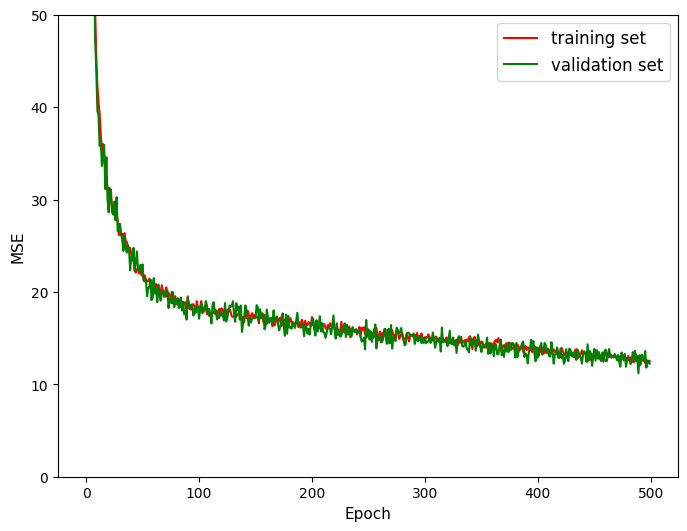

In [29]:
plt.figure(figsize=(8, 6), dpi=100)

plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.ylim(0, 50)

In [26]:
# Generate test data
test_batch_size = 500
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(zmin, zmax, test_batch_size)

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)



16/16 [==============================] - 0s 885us/step


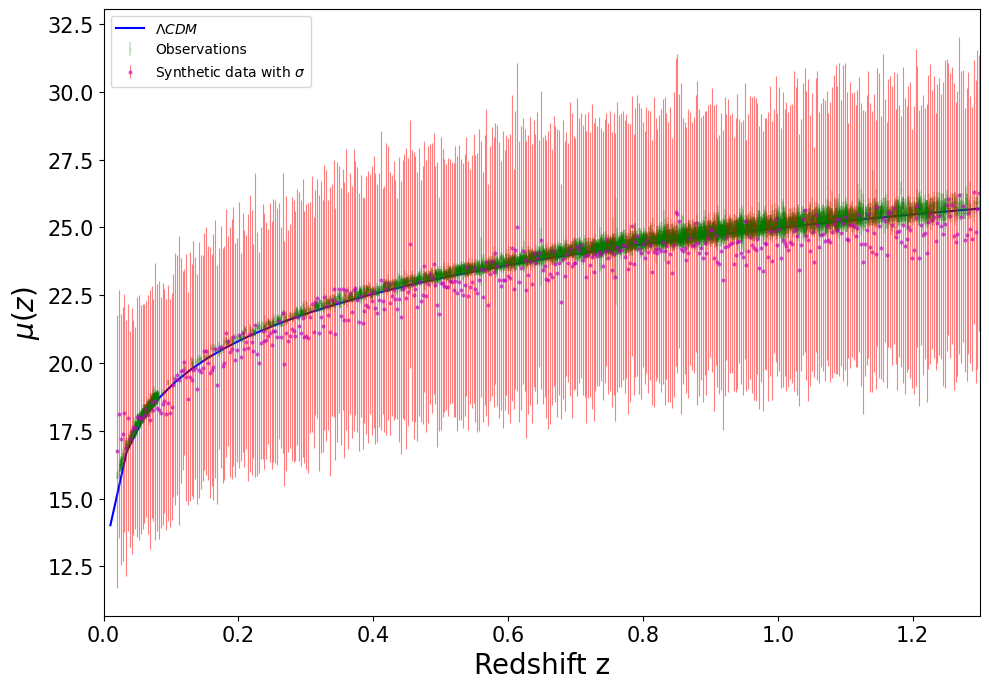

In [27]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=1, alpha=0.2, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,1.3)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

# zCMB 	MU 	errors